In [62]:
import importlib
import main

importlib.reload(main)

from main import BaseGBTM, ZIPModel, BernoulliModel, CensoredNormalModel
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp, expit, gammaln
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import statsmodels.api as sm



--- Running GBTM with CensoredNormalModel (KMeans Init) ---
Iteration 0: Total log-likelihood: -5706.66
Iteration 1: Total log-likelihood: -5694.12
Iteration 2: Total log-likelihood: -5693.66
Iteration 3: Total log-likelihood: -5693.58
Iteration 4: Total log-likelihood: -5693.57
Iteration 5: Total log-likelihood: -5693.57
Iteration 6: Total log-likelihood: -5693.57
Iteration 7: Total log-likelihood: -5693.57
Iteration 8: Total log-likelihood: -5693.57
Convergence achieved at iteration 8. Log-likelihood improvement less than tolerance.
Completed EM Algorithm for cnorm model.
  Final Log-Likelihood: -5693.57
  BIC: 11480.36
  AIC: 11417.14
  APPA: [0.93968793 0.99792625 0.93669028 0.97126562]
  OCC: [  44.25266779 1415.81560584   40.29805873  121.69136876]
  Entropy Information Criterion: 55.4839


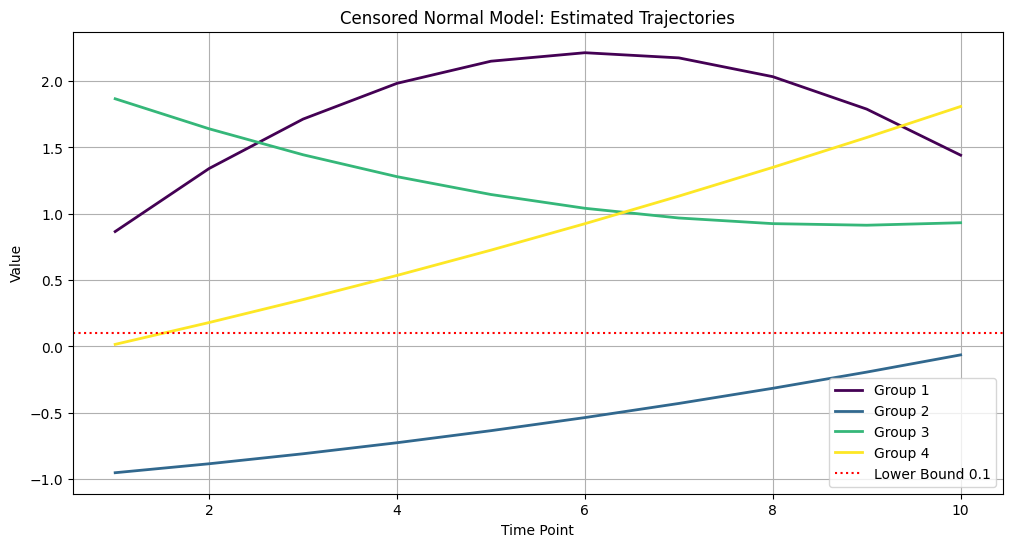

In [67]:
def generate_gbtm_data_censored_normal_v2(N, T, K, degree, sigma_noise, lower_bound, seed):
    np.random.seed(seed)
    X = np.vstack([np.arange(T) ** d for d in range(degree + 1)]).T
    true_betas = np.array([
        [1.0, 0.5, -0.05],   # Group 1
        [0.0, 0.2, 0.00],    # Group 2
        [2.0, -0.3, 0.02],   # Group 3
        [-1.0, 0.1, 0.00]    # Group 4
    ])[:K]
    true_assignments = np.random.choice(K, N)
    generated_data = np.zeros((N, T))
    for i in range(N):
        group_k = true_assignments[i]
        mu_true = X @ true_betas[group_k]
        noise = np.random.normal(0, sigma_noise, T)
        temp_data = mu_true + noise
        temp_data[temp_data < lower_bound] = lower_bound
        generated_data[i] = temp_data
    return generated_data, true_assignments, X, true_betas
        
def generate_bernoulli_data(N, T, K, degree, seed):
    np.random.seed(seed)
    X = np.vstack([np.arange(T) ** d for d in range(degree + 1)]).T
    true_betas_bernoulli = np.array([
        [0.5, 0.1, -0.01],
        [-1.5, 0.0, 0.00],
        [1.0, -0.2, 0.005]
    ])[:K]
    true_assignments_bernoulli = np.random.choice(K, N)
    generated_data_bernoulli = np.zeros((N, T))
    for i in range(N):
        group_k = true_assignments_bernoulli[i]
        prob_true = expit(X @ true_betas_bernoulli[group_k])
        generated_data_bernoulli[i] = (np.random.rand(T) < prob_true).astype(int)
    return generated_data_bernoulli, true_assignments_bernoulli, X, true_betas_bernoulli

def generate_zip_data(N, T, K, degree, seed):
    np.random.seed(seed)
    X = np.vstack([np.arange(T) ** d for d in range(degree + 1)]).T
    true_params_zip = [
        {"beta": np.array([1.0, 0.1, 0.0]), "gamma": np.array([-1.0, 0.0, 0.0])},
        {"beta": np.array([0.5, -0.05, 0.0]), "gamma": np.array([1.5, 0.0, 0.0])},
        {"beta": np.array([2.0, -0.2, 0.01]), "gamma": np.array([-0.5, 0.0, 0.0])}
    ][:K]
    true_assignments_zip = np.random.choice(K, N)
    generated_data_zip = np.zeros((N, T))
    for i in range(N):
        group_k = true_assignments_zip[i]
        beta_k = true_params_zip[group_k]["beta"]
        gamma_k = true_params_zip[group_k]["gamma"]
        lambda_t = np.exp(X @ beta_k)
        pi_t = expit(X @ gamma_k)
        for t in range(T):
            if np.random.rand() < pi_t[t]:
                generated_data_zip[i, t] = 0
            else:
                generated_data_zip[i, t] = np.random.poisson(lambda_t[t])
    return generated_data_zip, true_assignments_zip, X, true_params_zip


N_individuals = 500
T_time_points = 10
K_groups = 4
Degree_polynomial = 2

# --- Censored Normal Example ---
sigma_true_noise = 0.8
lower_bound = 0.1
generated_data_cnorm, true_assign_cnorm, X_design_matrix_cnorm, true_betas_cnorm = \
    generate_gbtm_data_censored_normal_v2(
        N=N_individuals, T=T_time_points, K=K_groups, degree=Degree_polynomial,
        sigma_noise=sigma_true_noise, lower_bound=lower_bound, seed=200
    )

print("\n--- Running GBTM with CensoredNormalModel (KMeans Init) ---")
gbtm_cnorm = BaseGBTM(
    data=generated_data_cnorm,
    K=K_groups,
    degree=Degree_polynomial,
    model=CensoredNormalModel(sigma=sigma_true_noise, lower_bound=lower_bound),
    max_iter=200, tol=1e-5, verbose=True, seed=42
)
gbtm_cnorm.fit()

# Plotting for CensoredNormalModel
plt.figure(figsize=(12, 6))
plt.title("Censored Normal Model: Estimated Trajectories")
plt.xlabel("Time Point")
plt.ylabel("Value")
colors = plt.cm.viridis(np.linspace(0, 1, K_groups))
estimated_trajectories_cnorm = gbtm_cnorm.model.get_mean_trajectory(gbtm_cnorm.X, gbtm_cnorm.params)
for k in range(K_groups):
    plt.plot(np.arange(T_time_points) + 1, estimated_trajectories_cnorm[k, :],
                color=colors[k], linestyle='-', linewidth=2, label=f'Group {k+1}')
plt.axhline(y=lower_bound, color='r', linestyle=':', label=f'Lower Bound {lower_bound}')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
assigned_groups = np.argmax(data, axis=1)

In [45]:
individuals_in_group_k = np.where(assigned_groups == 1)[0]

In [51]:
np.sum(data[individuals_in_group_k, 0]) / len(individuals_in_group_k)

np.float64(-0.3223764634399628)

In [ ]:
np.data[np.where(np.argmax(data, axis=1) == 2)[0], 0].mean()

np.float64(1.0)

In [253]:
# generate data for censored normal distribution
sample_betas = np.array([[0, 2, 2.1],
                         [0, 2, 1.9],
                         [0, 2.1, 2]])

N = 500
T = 10
K = 3
degree = 2
X = np.vstack([(np.arange(T) + 1)**d for d in range(degree + 1)]).T
sigma = 0.05
observation_group_assignments = np.random.randint(0, K, size=N)
data = np.zeros(shape=(N, T))

for n in range(N):
    for t in range(T):
        mu = np.array([1, t+1, (t+1)**2]) @ sample_betas[observation_group_assignments[n]]
        data[n, t] = np.random.normal(loc=mu, scale=sigma)

In [257]:
import numpy as np
import matplotlib.pyplot as plt

def generate_gbtm_data_censored_normal(
    N: int,
    T: int,
    K: int,
    degree: int,
    true_betas: np.ndarray = None,
    sigma_noise: float = 0.5,
    lower_bound: float = -np.inf,
    upper_bound: float = np.inf,
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates synthetic N*T data with K distinct groups, following a polynomial
    trend with Gaussian noise, and optionally applies censoring.

    Args:
        N (int): Total number of individuals/data points.
        T (int): Number of time points for each individual.
        K (int): Number of distinct underlying groups.
        degree (int): Degree of the polynomial trajectory for each group.
                      (e.g., 0 for constant, 1 for linear, 2 for quadratic).
        true_betas (np.ndarray, optional): K x (degree+1) array of true beta coefficients
                                           for each group. If None, default distinct betas
                                           are generated.
        sigma_noise (float, optional): Standard deviation of the Gaussian noise
                                       added to the true trajectories. Defaults to 0.5.
        lower_bound (float, optional): Lower censoring bound. Defaults to -np.inf.
        upper_bound (float, optional): Upper censoring bound. Defaults to np.inf.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]:
            - data (np.ndarray): The generated N*T data matrix.
            - true_assignments (np.ndarray): 1D array of true group assignments for each individual.
            - X_design (np.ndarray): The T x (degree+1) design matrix used for trajectories.
    """
    np.random.seed(seed)

    # Create the design matrix for time points (T x (degree+1))
    # E.g., for degree=1, X = [[1, 1], [1, 2], ..., [1, T]]
    time_points = np.arange(T) + 1 # Start from 1 for time
    X_design = np.vstack([time_points**d for d in range(degree + 1)]).T # (T, degree + 1)

    # If true_betas are not provided, generate some distinct ones
    if true_betas is None:
        true_betas = np.zeros((K, degree + 1))
        # Generate distinct intercepts and small random slopes/higher order coeffs
        initial_levels = np.linspace(0.1, 0.9, K) # Spread intercepts
        for k in range(K):
            true_betas[k, 0] = initial_levels[k] * 5 + np.random.uniform(-0.5, 0.5) # Scale and add variability
            for d in range(1, degree + 1):
                # Small random coefficients for higher degrees to create varied shapes
                true_betas[k, d] = np.random.uniform(-0.1, 0.1) * (0.5 ** d) # Reduce impact for higher degrees

        # Ensure some separation if they are too similar by default
        if K > 1 and degree >= 0:
            # Sort by intercept to ensure order
            sorted_indices = np.argsort(true_betas[:, 0])
            true_betas = true_betas[sorted_indices]
            # Add small increments to ensure separation, especially for low K
            for k_idx in range(1, K):
                # Ensure the current group's intercept is higher than the previous
                # by at least some margin, if not already.
                if true_betas[k_idx, 0] <= true_betas[k_idx-1, 0] + 0.1:
                    true_betas[k_idx, 0] = true_betas[k_idx-1, 0] + 0.2 + np.random.uniform(-0.05, 0.05)


    print(f"Generated True Beta Coefficients (K={K}, degree={degree}):\n{true_betas}\n")

    # Generate true group assignments for N individuals
    true_assignments = np.random.choice(K, N)

    # Initialize data matrix
    data = np.zeros((N, T))

    # Generate data for each individual
    for i in range(N):
        group_idx = true_assignments[i]
        
        # Calculate the true mean trajectory for this individual's group
        # mu_true_i (shape T,) = X_design (T, degree+1) @ true_betas[group_idx] (degree+1,)
        mu_true_i = X_design @ true_betas[group_idx]

        # Add Gaussian noise
        noisy_trajectory = mu_true_i + np.random.normal(loc=0, scale=sigma_noise, size=T)

        # Apply censoring
        censored_trajectory = np.clip(noisy_trajectory, lower_bound, upper_bound)
        data[i, :] = censored_trajectory

    return data, true_assignments, X_design

In [264]:
model.params

{'beta': array([[ 0.37314545,  0.04558878,  0.01156115],
        [ 4.06297308,  0.03469743,  0.0051973 ],
        [ 2.60230381, -0.03604142, -0.01709076]])}

Generated True Beta Coefficients (K=3, degree=2):
[[ 0.37454012  0.04507143  0.0115997 ]
 [ 2.59865848 -0.03439814 -0.01720027]
 [ 4.05808361  0.03661761  0.00505575]]




--- Generating Data for Censored Normal Model (No Censoring) ---
Generated True Beta Coefficients (K=4, degree=2):
[[ 5.43404942e-01 -2.21630615e-02 -3.77412046e-03]
 [ 2.17810947e+00 -4.95281144e-02 -1.89215440e-02]
 [ 3.33741575e+00  3.25852755e-02 -1.81646705e-02]
 [ 4.57509333e+00  3.91321954e-02 -1.45398939e-02]]



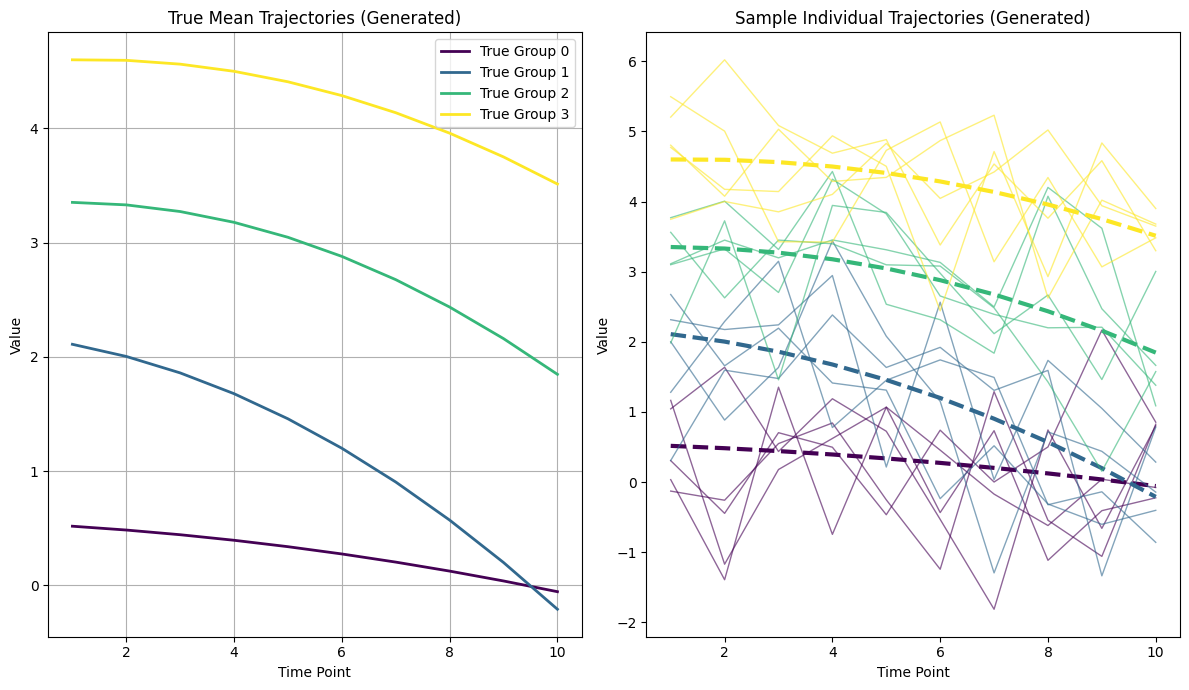


--- Generating Data for Censored Normal Model (With Lower Censoring) ---
Generated True Beta Coefficients (K=4, degree=2):
[[ 0.51639863  0.00706676 -0.02357629]
 [ 1.50485499  0.0185277   0.01669484]
 [ 2.97363289  0.03936131  0.01107719]
 [ 4.18993895  0.00542276 -0.0073934 ]]

Generated censored data (min value): 0.1


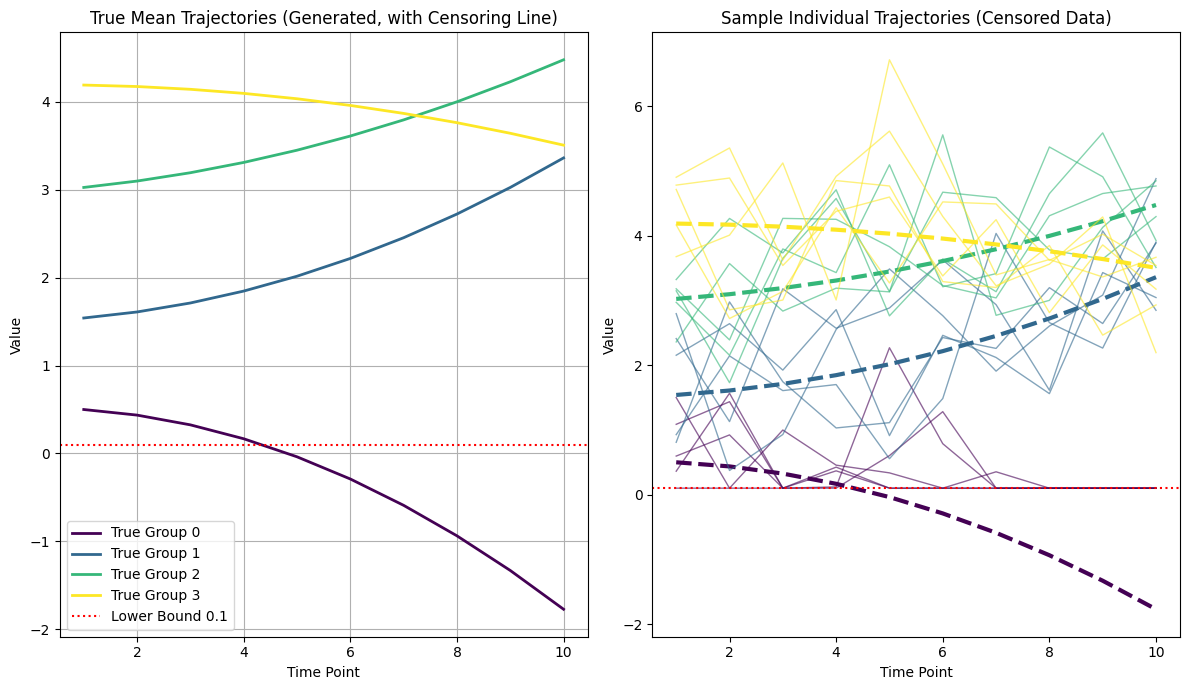

In [268]:
def generate_gbtm_data_censored_normal_v2(
    N: int, T: int, K: int, degree: int, **kwargs
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    data, true_assignments, X_design = generate_gbtm_data_censored_normal(N, T, K, degree, **kwargs)
    # Re-derive true_betas based on the seed, or pass them through
    # This is a bit tricky if they were randomly generated within the function.
    # A better approach is to return the internally generated true_betas
    
    # To get the same true_betas, we re-run the internal logic with the same seed
    np.random.seed(kwargs.get('seed', 42))
    _true_betas_internal = np.zeros((K, degree + 1))
    initial_levels = np.linspace(0.1, 0.9, K)
    for k_idx in range(K):
        _true_betas_internal[k_idx, 0] = initial_levels[k_idx] * 5 + np.random.uniform(-0.5, 0.5)
        for d in range(1, degree + 1):
            _true_betas_internal[k_idx, d] = np.random.uniform(-0.1, 0.1) * (0.5 ** d)
    if K > 1 and degree >= 0:
        sorted_indices = np.argsort(_true_betas_internal[:, 0])
        _true_betas_internal = _true_betas_internal[sorted_indices]
        for k_idx in range(1, K):
            if _true_betas_internal[k_idx, 0] <= _true_betas_internal[k_idx-1, 0] + 0.1:
                _true_betas_internal[k_idx, 0] = _true_betas_internal[k_idx-1, 0] + 0.2 + np.random.uniform(-0.05, 0.05)
    
    return data, true_assignments, X_design, _true_betas_internal


# Example 1: Generate data with default distinct betas and no censoring
print("\n--- Generating Data for Censored Normal Model (No Censoring) ---")
generated_data_1, true_assign_1, X_design_1, true_betas_1 = generate_gbtm_data_censored_normal_v2(
    N=N_individuals, T=T_time_points, K=K_groups, degree=Degree_polynomial,
    sigma_noise=0.8,
    seed=100
)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1) # Plot 1: True Mean Trajectories
plt.title("True Mean Trajectories (Generated)")
plt.xlabel("Time Point")
plt.ylabel("Value")
for k in range(K_groups):
    true_mean_trajectory = X_design_1 @ true_betas_1[k]
    plt.plot(np.arange(T_time_points) + 1, true_mean_trajectory,
                color=colors[k], linestyle='-', linewidth=2, label=f'True Group {k}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # Plot 2: Sample Individual Trajectories
plt.title("Sample Individual Trajectories (Generated)")
plt.xlabel("Time Point")
plt.ylabel("Value")
# Plot a few sample individuals from each true group
sample_per_group = 5
for k in range(K_groups):
    group_indices = np.where(true_assign_1 == k)[0]
    sample_indices = np.random.choice(group_indices, min(sample_per_group, len(group_indices)), replace=False)
    for idx in sample_indices:
        plt.plot(np.arange(T_time_points) + 1, generated_data_1[idx, :],
                    color=colors[k], alpha=0.6, linewidth=1)
    # Plot the true mean trajectory over the samples
    true_mean_trajectory = X_design_1 @ true_betas_1[k]
    plt.plot(np.arange(T_time_points) + 1, true_mean_trajectory,
                color=colors[k], linestyle='--', linewidth=3, label=f'True Mean {k}')
plt.tight_layout()
plt.show()


# Example 2: Generate data with censoring (e.g., lower bound at 0)
print("\n--- Generating Data for Censored Normal Model (With Lower Censoring) ---")
lower_censor_val = 0.1
generated_data_2, true_assign_2, X_design_2, true_betas_2 = generate_gbtm_data_censored_normal_v2(
    N=N_individuals, T=T_time_points, K=K_groups, degree=Degree_polynomial,
    sigma_noise=0.8,
    lower_bound=lower_censor_val, # Censor values below 0.1
    seed=101
)
print(f"Generated censored data (min value): {np.min(generated_data_2)}")

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title("True Mean Trajectories (Generated, with Censoring Line)")
plt.xlabel("Time Point")
plt.ylabel("Value")
for k in range(K_groups):
    true_mean_trajectory = X_design_2 @ true_betas_2[k]
    plt.plot(np.arange(T_time_points) + 1, true_mean_trajectory,
                color=colors[k], linestyle='-', linewidth=2, label=f'True Group {k}')
plt.axhline(y=lower_censor_val, color='r', linestyle=':', label=f'Lower Bound {lower_censor_val}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Sample Individual Trajectories (Censored Data)")
plt.xlabel("Time Point")
plt.ylabel("Value")
for k in range(K_groups):
    group_indices = np.where(true_assign_2 == k)[0]
    sample_indices = np.random.choice(group_indices, min(sample_per_group, len(group_indices)), replace=False)
    for idx in sample_indices:
        plt.plot(np.arange(T_time_points) + 1, generated_data_2[idx, :],
                    color=colors[k], alpha=0.6, linewidth=1)
    true_mean_trajectory = X_design_2 @ true_betas_2[k]
    plt.plot(np.arange(T_time_points) + 1, true_mean_trajectory,
                color=colors[k], linestyle='--', linewidth=3, label=f'True Mean {k}')
plt.axhline(y=lower_censor_val, color='r', linestyle=':', label=f'Lower Bound {lower_censor_val}')
plt.tight_layout()
plt.show()

In [270]:

N = 500
T = 10
K = 4
degree = 2
sigma = 0.8 # This should ideally match the sigma you pass to CensoredNormalModel
lower_bound = 0.1 # Example lower bound

generated_data, true_assignments, X_design_matrix, true_betas = generate_gbtm_data_censored_normal_v2(
    N=N, T=T, K=K, degree=degree,
    sigma_noise=sigma, lower_bound=lower_bound, seed=200
)

Generated True Beta Coefficients (K=4, degree=2):
[[ 9.47632257e-01 -2.73452579e-02  4.72100722e-03]
 [ 1.76164202e+00  2.64140687e-02 -2.48569704e-02]
 [ 3.02409035e+00  4.09694886e-02 -2.19595073e-03]
 [ 4.98180271e+00  3.67356990e-02  2.43013756e-02]]



In [271]:

model = BaseGBTM(data, K, degree, model=CensoredNormalModel(sigma=sigma), tol=1e-32)
model.fit()

Iteration 0: Total log-likelihood: -918449.57
Iteration 1: Total log-likelihood: -918449.57
Completed EM Algorithm


In [272]:
model.params

{'beta': array([[ 7.44222139, -2.84255971,  0.30648238],
        [ 1.53221832,  1.41699882, -0.16778837],
        [ 1.68488213, -0.6236806 ,  0.0892991 ],
        [-0.37532527,  2.1173726 , -0.26524055]])}

In [108]:
def init_params(self, data, X, K, degree, random_state=42):  # Updated signature
    beta = np.zeros((K, degree + 1))

    kmeans = KMeans(n_clusters=K, random_state=random_state, n_init="auto")
    cluster_assignments = kmeans.fit_predict(data)

    for k in range(K):
        cluster_data = data[cluster_assignments == k]

        if len(cluster_data) > 0:
            Y_cluster_stacked = cluster_data.flatten()
            X_cluster_stacked = np.tile(X, (len(cluster_data), 1))

            try:
                # statsmodels.OLS needs an intercept if not already in X
                # Your X (design matrix) already has a column of ones if degree >= 0
                model_ols = sm.OLS(Y_cluster_stacked, X_cluster_stacked).fit()
                beta[k] = model_ols.params
            except Exception as e:
                print(
                    f"Warning: OLS initial fit failed for CensoredNormal cluster {k}. Using mean for intercept. Error: {e}"
                )
                beta[k, 0] = np.mean(cluster_data)
        else:
            beta[k, 0] = np.random.normal(0, 0.1)
            print(
                f"Warning: Cluster {k} was empty during CensoredNormal init. Using random intercept."
            )

    return {"beta": beta}

params = init_params(None, data, X, K, degree)

In [119]:
class SELF:
    def __init__(selfi, sigma=0.05, lower_bound=None, upper_bound=None):
        selfi.sigma = sigma
        selfi.lower_bound = -np.inf if lower_bound is None else lower_bound
        selfi.upper_bound = np.inf if upper_bound is None else upper_bound

In [131]:
self = SELF(sigma=0.05)

In [132]:
self.lower_bound

-inf

In [133]:
log_likelihood(self, data, X, K, params)

array([[-1.68153793e+08,  1.79061559e+01, -4.72894550e+07],
       [-1.68211347e+08,  1.66837051e+01, -4.72589306e+07],
       [ 1.37569175e+01, -1.68200452e+08, -3.93377851e+08],
       ...,
       [-1.68223886e+08,  1.59956804e+01, -4.72522827e+07],
       [ 1.77173496e+01, -1.68213288e+08, -3.93396953e+08],
       [-3.93352204e+08, -4.72698800e+07,  1.66794927e+01]],
      shape=(500, 3))

In [134]:
log_likelihood(self, data, X, K, params)

array([[-1.68153793e+08,  1.79061559e+01, -4.72894550e+07],
       [-1.68211347e+08,  1.66837051e+01, -4.72589306e+07],
       [ 1.37569175e+01, -1.68200452e+08, -3.93377851e+08],
       ...,
       [-1.68223886e+08,  1.59956804e+01, -4.72522827e+07],
       [ 1.77173496e+01, -1.68213288e+08, -3.93396953e+08],
       [-3.93352204e+08, -4.72698800e+07,  1.66794927e+01]],
      shape=(500, 3))

In [135]:
def log_likelihood(self, data, X, K, params):
        N = data.shape[0]
        log_lik = np.zeros(shape=(N, K))
        beta = params["beta"]

        is_left_censored = data <= self.lower_bound
        is_right_censored = data >= self.upper_bound
        is_observed_interval = (data > self.lower_bound) & (data < self.upper_bound)

        for k in range(K):
            mu_k = np.broadcast_to(X @ beta[k], data.shape)
            ll_obs = np.zeros_like(data, dtype=float)
            
            ll_obs[is_left_censored] = norm.logcdf(
                self.lower_bound, loc=mu_k[is_left_censored], scale=self.sigma
            )
            ll_obs[is_right_censored] = norm.logsf(
                self.upper_bound, loc=mu_k[is_right_censored], scale=self.sigma
            )
            ll_obs[is_observed_interval] = norm.logpdf(
                data[is_observed_interval], loc=mu_k[is_observed_interval], scale=self.sigma
            )

            log_lik[:, k] = np.sum(ll_obs, axis=1)

        return log_lik

In [204]:
def neg_loglikelihood(beta_k, data, X, post_k):
        mu_k = np.broadcast_to(X @ beta_k, data.shape)

        is_left_censored = data <= self.lower_bound
        is_right_censored = data >= self.upper_bound
        is_observed_interval = (data > self.lower_bound) & (data < self.upper_bound)

        ll_obs = np.zeros_like(data, dtype=float)
        
        ll_obs[is_left_censored] = norm.logcdf(
            self.lower_bound, loc=mu_k[is_left_censored], scale=self.sigma
        )
        ll_obs[is_right_censored] = norm.logsf(
            self.upper_bound, loc=mu_k[is_right_censored], scale=self.sigma
        )
        ll_obs[is_observed_interval] = norm.logpdf(
            data[is_observed_interval], loc=mu_k[is_observed_interval], scale=self.sigma
        )

        # Ensure post_flat is correctly aligned (N,1) and ll_obs sum (N,1)
        # Sum ll_obs for each individual first
        sum_ll_obs_per_individual = np.sum(ll_obs, axis=1) # Shape (N,)
        return -np.sum(post_k * sum_ll_obs_per_individual) # Post is (N,)

In [205]:
def fit(self, data, X, K, post, params):
    beta = np.zeros_like(params["beta"])
    for k in range(K):
        # For fit, post[:,k] are the weights specific to group k for each individual
        results = minimize(
            neg_loglikelihood,
            params["beta"][k],
            args=(data, X, post[:, k]), # Pass the correct posterior column
            method="L-BFGS-B",
        )
        beta[k] = results.x
    return {"beta": beta}

In [206]:
log_likelihood(self, data, X, K, params).sum(axis=0)

array([-9.43287466e+10, -3.22661970e+10, -6.74822353e+10])

In [208]:
for k in range(K):
    print(f"{k}: {neg_loglikelihood(params["beta"][k], data, X, post[:, k])}")

0: 31442915206.74923
1: 10755398898.985405
2: 22494078211.45182


In [210]:
params = fit(self, data, X, K, post, params)

In [211]:
log_likelihood(self, data, X, K, params).sum(axis=0)

array([-3.08120539e+10, -3.08120813e+10, -3.08120539e+10])

In [212]:
for k in range(K):
    print(f"{k}: {neg_loglikelihood(params["beta"][k], data, X, post[:, k])}")

0: 10270684528.952686
1: 10270693648.870945
2: 10270684529.037926


In [60]:
# 1. Prepare your data
# Let's create some dummy data as an example.
# N = number of data points/individuals
# T = number of dimensions/time points for each data point
N = 100  # For example, 100 individuals
T = 5    # For example, 5 time points for each individual
X = np.vstack([(np.arange(T) + 1)**d for d in range(degree + 1)]).T

# Generate some example data
# Imagine these are 3 underlying "true" groups with different means
np.random.seed(42) # for reproducibility

group1_data = np.random.normal(loc=0.2, scale=0.1, size=(30, T))
group2_data = np.random.normal(loc=0.5, scale=0.1, size=(40, T))
group3_data = np.random.normal(loc=0.8, scale=0.1, size=(30, T))

# Combine them into your full dataset
data = np.vstack((group1_data, group2_data, group3_data))

# You should replace 'data' with your actual 'data' variable from your GBTM code.
# Ensure 'data' has the shape (N, T)
print(f"Shape of the data: {data.shape} (N individuals, T dimensions/time points)")


# 2. Define the number of clusters (K)
K = 3 # This K should be the same as the K you use in your GBTM (e.g., 4 in your image)

# 3. Initialize and fit the KMeans model
# n_init='auto' is recommended for robust initialization
# random_state is for reproducibility of the KMeans clustering itself
kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
kmeans.fit(data)

# 4. Get the cluster assignments for each data point
# Each element in 'cluster_assignments' corresponds to a row in your 'data' array.
# The value is the cluster index (0 to K-1) that the data point belongs to.
cluster_assignments = kmeans.labels_

print("\nCluster assignments for each data point (first 10):")
print(cluster_assignments[:10])
print(f"Total unique clusters found: {np.unique(cluster_assignments)}")

# 5. You can also get the cluster centroids (mean of each cluster)
# These centroids are T-dimensional, representing the "average" trajectory for each cluster.
cluster_centroids = kmeans.cluster_centers_
print("\nCluster Centroids (K, T):")
print(cluster_centroids)
print(f"Shape of cluster centroids: {cluster_centroids.shape}")



initial_betas_from_kmeans = np.zeros((K, T)) # simplified, just showing mean of assigned cluster
for k_idx in range(K):
    # Select data points assigned to this cluster
    assigned_data = data[cluster_assignments == k_idx]
    if len(assigned_data) > 0:
        # For simplicity, let's just take the mean of the data for this cluster
        # This is not a full GLM fit, but demonstrates getting cluster-specific initial values
        initial_betas_from_kmeans[k_idx, :] = np.mean(assigned_data, axis=0)
    else:
        # Handle empty clusters if K is too high for the data structure
        initial_betas_from_kmeans[k_idx, :] = np.random.rand(T) # Fallback random init

print("\nExample: Initial beta values (simplified, just mean of data in cluster):")
print(initial_betas_from_kmeans)

Shape of the data: (100, 5) (N individuals, T dimensions/time points)

Cluster assignments for each data point (first 10):
[2 2 2 2 2 2 2 2 2 2]
Total unique clusters found: [0 1 2]

Cluster Centroids (K, T):
[[0.48897318 0.51151631 0.50972619 0.50385941 0.51665874]
 [0.79445712 0.80397041 0.76716608 0.84417194 0.80181611]
 [0.20532958 0.20632592 0.1885745  0.19336833 0.16523823]]
Shape of cluster centroids: (3, 5)

Example: Initial beta values (simplified, just mean of data in cluster):
[[0.48897318 0.51151631 0.50972619 0.50385941 0.51665874]
 [0.79445712 0.80397041 0.76716608 0.84417194 0.80181611]
 [0.20532958 0.20632592 0.1885745  0.19336833 0.16523823]]


In [ ]:
K=3
degree = 2

beta = np.zeros((K, degree + 1))
kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
cluster_assignments = kmeans.fit_predict(data)

In [63]:
cluster_assignments

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [76]:
beta

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
for k in range(K):
    cluster_data = data[cluster_assignments == k]
    
    if len(cluster_data) > 0:
        # For CensoredNormal, the underlying model is linear regression for mu_k
        # So we can use OLS for initialization
        Y_cluster_stacked = cluster_data.flatten()
        X_cluster_stacked = np.tile(X, (len(cluster_data), 1))
        
        try:
            # statsmodels.OLS needs an intercept if not already in X
            # Your X (design matrix) already has a column of ones if degree >= 0
            model_ols = sm.OLS(Y_cluster_stacked, X_cluster_stacked).fit()
            beta[k] = model_ols.params
        except Exception as e:
            print(f"Warning: OLS initial fit failed for CensoredNormal cluster {k}. Using mean for intercept. Error: {e}")
            beta[k, 0] = 
    else:
        beta[k, 0] = np.random.normal(0, 0.1)
        print(f"Warning: Cluster {k} was empty during CensoredNormal init. Using random intercept.")



In [85]:
np.mean(data[cluster_assignments == 0])

np.float64(0.5061467653712829)

In [82]:
X @ beta.T

array([[0.4932376 , 0.79277128, 0.20529428],
       [0.50305851, 0.79610495, 0.20363189],
       [0.50951309, 0.80087748, 0.1968684 ],
       [0.51260135, 0.80708886, 0.18500383],
       [0.51232328, 0.81473909, 0.16803816]])

In [7]:
test = CensoredNormalModel(sigma=0.05, lower_bound=0.05, upper_bound=1)

In [10]:
test.sigma

0.05

In [ ]:
data = np.random.rand(500, 10)
data = np.random.randint(0, 2, (500, 10))

In [746]:
np.random.normal(loc=5, scale=0.05)

5.024835707650562

In [87]:
K=3
degree = 2

beta = np.zeros((K, degree + 1))
kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
cluster_assignments = kmeans.fit_predict(data)

<Axes: xlabel='variable', ylabel='value'>

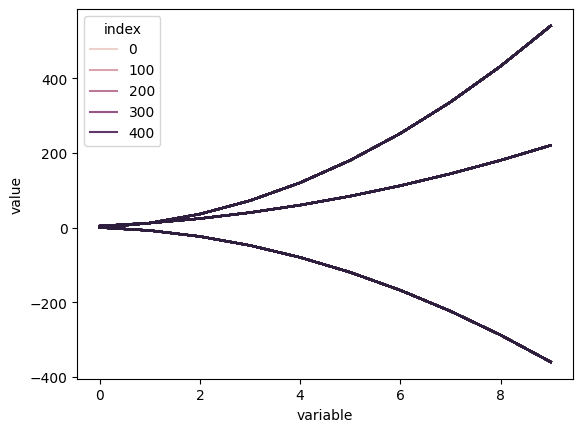

In [104]:
data_df = pd.DataFrame(data)
data_df["group"] = cluster_assignments
data_df = data_df.reset_index().melt(id_vars=["index", "group"], value_vars=[i for i in range(10)])
sns.lineplot(data=data_df, x="variable", y="value", hue="index")

In [103]:
data.shape

(500, 10)

In [93]:
observation_group_assignments == cluster_assignments

array([ True,  True, False, False, False,  True, False, False, False,
       False,  True, False,  True,  True, False,  True, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False,  True,  True, False,
        True,  True, False,  True, False,  True, False, False,  True,
       False, False, False,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False,  True,  True,  True, False, False, False,  True, False,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
       False, False,  True, False,  True, False,  True, False, False,
        True, False,

In [99]:
(observation_group_assignments == 2).sum()

np.int64(169)

In [101]:
(cluster_assignments == 1).sum()

np.int64(169)

In [ ]:
data_df = pd.DataFrame(data)
data_df["group"] = observation_group_assignments
data_df = data_df.reset_index().melt(id_vars=["index", "group"], value_vars=[i for i in range(10)])
sns.lineplot(data=data_df, x="variable", y="value", hue="index")

<Axes: xlabel='variable', ylabel='value'>

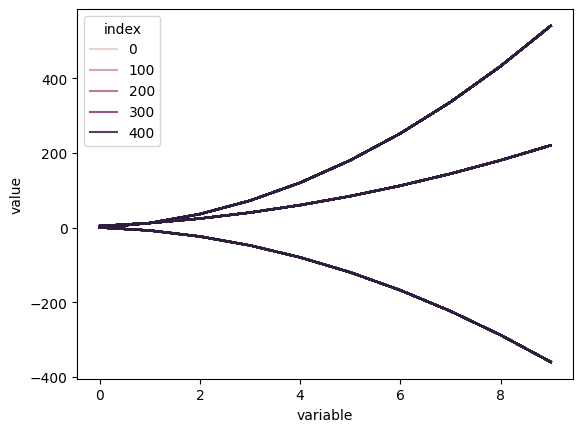

In [24]:
data_df["variable"]

0           0
1           0
2           0
3           0
4           0
        ...  
5495    group
5496    group
5497    group
5498    group
5499    group
Name: variable, Length: 5500, dtype: object

In [19]:
observation_group_assignments

array([2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 0, 1, 2, 2, 1, 2, 2, 0,
       2, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0, 1,
       0, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 1, 2, 2, 2, 1, 0, 0, 0,
       1, 2, 0, 2, 1, 0, 0, 1, 0, 2, 1, 0, 2, 2, 0, 0, 1, 1, 2, 1, 1, 2,
       0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 2, 2, 0, 2,
       2, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 1, 1, 0,
       0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 1, 2, 1, 0,
       0, 2, 2, 2, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2,
       1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0,
       2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2,
       1, 0, 0, 1, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 2, 0,
       1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 1, 2, 2, 1,

In [18]:
data_df

,index,variable,value
0,0,0,0.013504
1,1,0,-0.013962
2,2,0,0.005577
3,3,0,4.014750
4,4,0,0.015151
...,...,...,...
4995,495,9,-359.866790
4996,496,9,220.065170
4997,497,9,-359.991771
4998,498,9,539.975395


In [761]:
model = BaseGBTM(data, K=3, degree=2, model=CensoredNormalModel(sigma=0.05, lower_bound=0, upper_bound=10), tol=1e-6)
model.fit()

Iteration 0: Total log-likelihood: -21935238.97
Iteration 1: Total log-likelihood: -21935239.03
Completed EM Algorithm


In [744]:
model = BaseGBTM(data, K=4, degree=3, model=BernoulliModel(), tol=1e-6)
model.fit()

Iteration 0: Total log-likelihood: -3462.06
Iteration 1: Total log-likelihood: -3461.81
Iteration 2: Total log-likelihood: -3461.52
Iteration 3: Total log-likelihood: -3461.22
Iteration 4: Total log-likelihood: -3460.89
Iteration 5: Total log-likelihood: -3460.55
Iteration 6: Total log-likelihood: -3460.20
Iteration 7: Total log-likelihood: -3459.85
Iteration 8: Total log-likelihood: -3459.51
Iteration 9: Total log-likelihood: -3459.19
Iteration 10: Total log-likelihood: -3458.89
Iteration 11: Total log-likelihood: -3458.63
Iteration 12: Total log-likelihood: -3458.39
Iteration 13: Total log-likelihood: -3458.19
Iteration 14: Total log-likelihood: -3458.01
Iteration 15: Total log-likelihood: -3457.86
Iteration 16: Total log-likelihood: -3457.72
Iteration 17: Total log-likelihood: -3457.60
Iteration 18: Total log-likelihood: -3457.49
Iteration 19: Total log-likelihood: -3457.39
Iteration 20: Total log-likelihood: -3457.30
Iteration 21: Total log-likelihood: -3457.21
Iteration 22: Total 

In [745]:
model.params

{'beta': array([[ 0.22563119, -0.54975394,  0.1493189 , -0.01075024],
        [-0.32297554,  0.29517253, -0.09420724,  0.0073693 ],
        [-0.11986683,  0.40758009, -0.09458025,  0.00571939],
        [ 5.42223575, -4.44122242,  0.94277555, -0.05452288]])}

In [722]:
test.log_likelihood(data, model.X, 3, params).sum()

np.float64(-31214.293219192074)

In [717]:
test.log_likelihood(data, model.X, 3, params).sum()

np.float64(-23816.070515888998)

In [ ]:

        log_lik = self.model.log_likelihood(self.data, self.X, self.K, self.params)
        log_post = (
            log_lik
            + np.log(self.pi + 1e-16)
            - logsumexp(log_lik + np.log(self.pi + 1e-16), axis=1, keepdims=True)
        )
        self.post = np.exp(log_post)

In [ ]:
test.log_likelihood(data, model.X, 3, params)

In [716]:
params = test.fit(data, model.X, 3, model.post, params)

In [705]:
model.fit()

Iteration 0: Total log-likelihood: -7938.69
Iteration 1: Total log-likelihood: -7938.69
Completed EM Algorithm


In [701]:
model.pi

array([0.28813665, 0.50309055, 0.2087728 ])

In [574]:
mu_k = np.broadcast_to(model.X @ beta[0], data.shape)

In [576]:
mu_k.shape

(50, 10)

In [580]:
lower_bound = 0.2
upper_bound = 0.8

In [581]:
# create boolean masks
is_left_censored = data <= lower_bound
is_right_censored = data >= upper_bound
is_observed_interval = (data > lower_bound) & (data < upper_bound)

In [ ]:
sigma= 0.05
log_lik = np.zeros(shape=(50, 3))
ll_obs = np.full(shape=(50,10), fill_value=-99999)
z_lower = (lower_bound - mu_k) / sigma
z_upper = (upper_bound - mu_k) / sigma
ll_obs[is_left_censored] = norm.logcdf(lower_bound, loc=mu_k, scale=sigma)[is_left_censored]
ll_obs[is_right_censored] = norm.logsf(upper_bound, loc=mu_k, scale=sigma)[is_right_censored]
ll_obs[is_observed_interval] = norm.logpdf(data, loc=mu_k, scale=sigma)[is_observed_interval]

500


In [674]:
(ll_obs == -99999).sum()

np.int64(0)

In [503]:
# --- 1. Define ZIP parameters for 3 different groups ---
# Each tuple represents (zero_inflation_probability, poisson_lambda)
GROUP_PARAMS = [
    (0.1, 2.0),   # Group 0: Low zeros, low count mean
    (0.1, 10),   # Group 1: Medium zeros, medium count mean
    (0.9, 10)   # Group 2: High zeros, high count mean (if it's not a zero)
]
NUM_GROUPS = len(GROUP_PARAMS)

# --- 2. Define Matrix Size ---
NUM_OBSERVATIONS = 50 # Number of rows
NUM_FEATURES = 10    # Number of columns (e.g., time points or different features)

# --- 3. Initialize Matrix and Assign Groups to Observations ---
generated_data = np.zeros((NUM_OBSERVATIONS, NUM_FEATURES), dtype=int)
# Randomly assign each of the 50 observations to one of the 3 groups (0, 1, or 2)
# This determines which set of (p, lambda) params each row will use
observation_group_assignments = np.random.randint(0, NUM_GROUPS, size=NUM_OBSERVATIONS)

# --- 4. Populate the Matrix with ZIP samples ---
for i in range(NUM_OBSERVATIONS):
    # Get the specific (p, lambda) for the current observation's group
    p_zi, lam = GROUP_PARAMS[observation_group_assignments[i]]

    for j in range(NUM_FEATURES):
        # Decide if it's an inflated zero or a Poisson count
        if np.random.rand() < p_zi:
            generated_data[i, j] = 0 # An "inflated" zero
        else:
            generated_data[i, j] = np.random.poisson(lam) # A count from the Poisson part

# --- Output the generated matrix and assignments ---
print(f"Generated {NUM_OBSERVATIONS}x{NUM_FEATURES} ZIP Data Matrix:\n")
print(generated_data)

print("\n\nGroup Assignments for each of the 50 observations (rows):\n")
print(observation_group_assignments)

Generated 50x10 ZIP Data Matrix:

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 1  0  3  5  3  0  1  0  7  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 5  1  2  3  1  2  1  1  2  3]
 [ 0  3  1  2  3  3  2  3  1  1]
 [10 18  0  0  0  0  0  0  0  0]
 [16 11 20 10  6  6 12 10  9  7]
 [ 0  0  0 10  0  0  8  0  4  0]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 1  3  3  2  1  2  2  0  1  1]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 5 13 11 14  0 10 16 13  6 11]
 [ 1  1  2  1  3  3  1  3  2  2]
 [ 0  0 14 12  5 10 13 10  9 15]
 [ 7 14 11 10  7  7 12 12  9  0]
 [ 9 10  0 15  4 12  5 11  8  9]
 [ 9  6  9  5  6  9 13  0  0 12]
 [ 4  1  3  0  2  1  2  6  0  3]
 [ 5  0  1  2  2  4  2  0  3  1]
 [12  9  5  7 12  6 12  8 12 14]
 [ 7  9 11 11 11  9  5  0  3 10]
 [ 4  2  2  3  2  0  0  3  4  2]
 [ 4  3  4  2  0  2  1  5  1  2]
 [ 2  2  0  5  1  1  2  2  2  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10 11]
 [ 7  0  

In [511]:
data = np.random.randint(0, 2, size=(50,10))

In [515]:
model = BaseGBTM(data, 3, 2, model=BernoulliModel(), max_iter=1000, tol=1e-6)

In [516]:
model.fit()

Iteration 0: Total log-likelihood: -344.71
Iteration 10: Total log-likelihood: -342.31
Iteration 20: Total log-likelihood: -341.57
Iteration 30: Total log-likelihood: -340.77
Iteration 40: Total log-likelihood: -340.46
Iteration 50: Total log-likelihood: -340.44
Iteration 60: Total log-likelihood: -340.43
Iteration 70: Total log-likelihood: -340.43
Iteration 80: Total log-likelihood: -340.42
Iteration 90: Total log-likelihood: -340.42
Iteration 100: Total log-likelihood: -340.42
Iteration 110: Total log-likelihood: -340.42
Iteration 120: Total log-likelihood: -340.42
Iteration 130: Total log-likelihood: -340.42
Iteration 140: Total log-likelihood: -340.42
Completed EM Algorithm


In [520]:
test = BernoulliModel()

In [525]:
params = test.init_params(data, 3, 2)

In [527]:
params

{'beta': array([[0.37896064, 0.        , 0.        ],
        [0.53837174, 0.        , 0.        ],
        [0.77652628, 0.        , 0.        ]])}

In [544]:
beta = params["beta"]

In [545]:
beta

array([[0.37896064, 0.        , 0.        ],
       [0.53837174, 0.        , 0.        ],
       [0.77652628, 0.        , 0.        ]])

In [549]:
model.X

array([[  1,   1,   1],
       [  1,   2,   4],
       [  1,   3,   9],
       [  1,   4,  16],
       [  1,   5,  25],
       [  1,   6,  36],
       [  1,   7,  49],
       [  1,   8,  64],
       [  1,   9,  81],
       [  1,  10, 100]])

In [550]:
p = np.clip(expit(model.X @ beta[0]), 1e-12, 1-1e-12)

In [551]:
p

array([0.5936224, 0.5936224, 0.5936224, 0.5936224, 0.5936224, 0.5936224,
       0.5936224, 0.5936224, 0.5936224, 0.5936224])

In [552]:
ll_obs = np.sum(data[0] * np.log(p) + (1 - data[0]) * np.log(1-p))

In [553]:
ll_obs

np.float64(-8.24680368505242)

In [543]:
test.log_likelihood(data, model.X, K=3, params=params)

array([[ -8.24680369,  -8.9045994 ,  -9.99658251],
       [ -7.10992176,  -7.28948419,  -7.66700367],
       [ -5.97303984,  -5.67436898,  -5.33742482],
       [ -7.4888824 ,  -7.82785593,  -8.44352995],
       [ -5.97303984,  -5.67436898,  -5.33742482],
       [ -7.86784304,  -8.36622767,  -9.22005623],
       [ -6.73096112,  -6.75111246,  -6.89047738],
       [ -6.73096112,  -6.75111246,  -6.89047738],
       [ -6.73096112,  -6.75111246,  -6.89047738],
       [ -5.97303984,  -5.67436898,  -5.33742482],
       [ -5.97303984,  -5.67436898,  -5.33742482],
       [ -6.73096112,  -6.75111246,  -6.89047738],
       [ -6.73096112,  -6.75111246,  -6.89047738],
       [ -8.62576433,  -9.44297114, -10.77310879],
       [ -7.4888824 ,  -7.82785593,  -8.44352995],
       [ -7.86784304,  -8.36622767,  -9.22005623],
       [ -6.73096112,  -6.75111246,  -6.89047738],
       [ -7.86784304,  -8.36622767,  -9.22005623],
       [ -7.86784304,  -8.36622767,  -9.22005623],
       [ -7.4888824 ,  -7.82785

In [558]:
test.fit(data, model.X, model.K, model.post, params)

{'beta': array([[-3.15811800e-01,  9.61531397e-02, -2.06040478e-02],
        [ 5.71120882e-02,  2.43918017e-02,  8.86234595e-04],
        [ 1.81520229e+01, -3.63238802e+00,  1.74440869e-01]])}

In [557]:
params

{'beta': array([[0.37896064, 0.        , 0.        ],
        [0.53837174, 0.        , 0.        ],
        [0.77652628, 0.        , 0.        ]])}

In [483]:
model.pi

array([0.4, 0.3, 0.3])